In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pydicom
from torch import nn
from torch.utils.data import DataLoader,Dataset
import scipy
import h5py

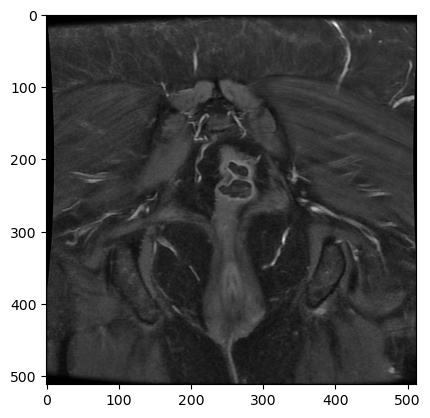

In [4]:
from pydicom import dcmread
file_img = dcmread("DICOM/PA0/ST0/SE16/IM2")
img_original = dcmread("DICOM/PA0/ST0/SE16/IM2").pixel_array
plt.imshow(img_original, cmap='gray')

In [4]:
img_original.shape

(512, 512)

In [4]:
file_img

Dataset.file_meta -------------------------------
(0002, 0000) File Meta Information Group Length  UL: 196
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: MR Image Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 1.2.840.113619.2.379.176156465384041.20938.1722071535431.5224
(0002, 0010) Transfer Syntax UID                 UI: Explicit VR Little Endian
(0002, 0012) Implementation Class UID            UI: 1.2.840.113619.6.379
(0002, 0013) Implementation Version Name         SH: 'aia 6.0 (2.29)'
-------------------------------------------------
(0008, 0000) Group Length                        UL: 830
(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0008) Image Type                          CS: ['ORIGINAL', 'PRIMARY', 'OTHER']
(0008, 0016) SOP Class UID                       UI: MR Image Storage
(0008, 0018) SOP Instance UID                    UI: 1.2.840.113619.2.379.176156465384041.2

In [ ]:
file_img

In [5]:
def sampling(img, scan, new_spacing=[1,1]):
    # when scanning there are different pixel spaces across all scans so to normalise it we've made a function to get all of it to a base spacing of 1x1x1
    spacing = np.array(list(scan.PixelSpacing), dtype=np.float32)
    resize_factor = spacing / new_spacing
    new_real_shape = img.shape * resize_factor
    new_shape = np.round(new_real_shape)
    real_resize_factor = new_shape / img.shape
    new_spacing = spacing / real_resize_factor
    img = scipy.ndimage.interpolation.zoom(img, real_resize_factor, mode='nearest')
    return img, new_spacing

def normalize(arr):
    arr_min = arr.min()
    arr_max = arr.max()
    arr = (arr - arr_min) / (arr_max - arr_min) * 255
    return arr

# normalized_img = normalize(img)
# plt.imshow(normalized_img, cmap='gray')
# sampled_img, new_spacing = sampling(normalized_img, file_img)
# plt.imshow(sampled_img, cmap='gray')

In [5]:
from torch import nn
from torch.utils.data import DataLoader, Dataset

In [10]:
class Reducer(nn.Module):
    def __init__(self,transform):
        super().__init__()
        self.encoder = nn.Sequential(
            #input = 1x512x512
            nn.Conv2d(1,10,3,stride=1,padding="same"), # 10x510x510
            nn.ReLU(),
            nn.MaxPool2d(2), # 10x255x255
            nn.Conv2d(10,16,3,padding="same"), # 16x253x253
            nn.ReLU(),
            nn.MaxPool2d(2) #16x126x126 
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(16,10,2,stride=2), #10x252x252
            nn.ReLU(),
            nn.ConvTranspose2d(10,1,2,stride=2), #1x504x504
            nn.Sigmoid()
        )
    
    def forward(self,x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [12]:
import torch
from torchvision.datasets import ImageFolder

import torchvision.transforms as transforms
import PIL.Image as Image
# Define the path to the data folder
data_folder = 'data/test'

# Define the transformations to apply to the images
transform = transforms.Compose([
    transforms.Lambda(lambda x: x.convert('L')),
    transforms.ToTensor(),
    transforms.Resize((512,512)),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

# Create the dataset
dataset = ImageFolder(data_folder, transform=transform)

# Create the data loader
data_loader = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=True)

# create a training loop to train the autoencoder model
model = Reducer(transform).to('mps')
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

for epoch in range(5):
    for i,(img,y) in enumerate(data_loader):
        img = img.to('mps')
        optimizer.zero_grad()
        output = model(img)
        loss = criterion(output, img)
        loss.backward()
        optimizer.step()
        if i % 100 == 0:
            print(f"Batch {i}, Loss: {loss.item()}")
    print(f'Epoch {epoch+1}, Loss: {loss.item()}')

Batch 0, Loss: 1.1425682306289673
Epoch 1, Loss: 1.2351799011230469
Batch 0, Loss: 1.1094549894332886
Epoch 2, Loss: 1.2620552778244019
Batch 0, Loss: 1.1619423627853394
Epoch 3, Loss: 1.174947738647461
Batch 0, Loss: 1.087796926498413
Epoch 4, Loss: 1.0752149820327759
Batch 0, Loss: 0.9954185485839844
Epoch 5, Loss: 0.8559886813163757


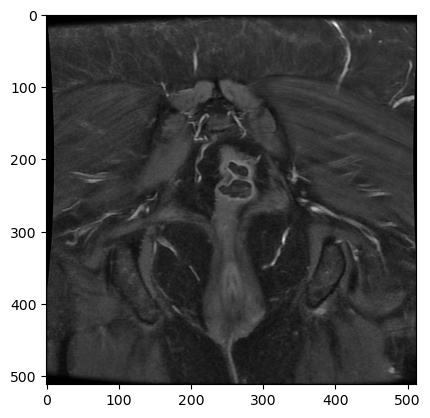

In [13]:
model.eval()
plt.imshow(img_original,cmap='gray')
img_reshape = np.array(img_original.reshape(1,512,512))
normalized_img = normalize(img_original)
pil_img = Image.fromarray(normalized_img)

In [14]:
output = model(transform(pil_img).unsqueeze(0).to('mps'))

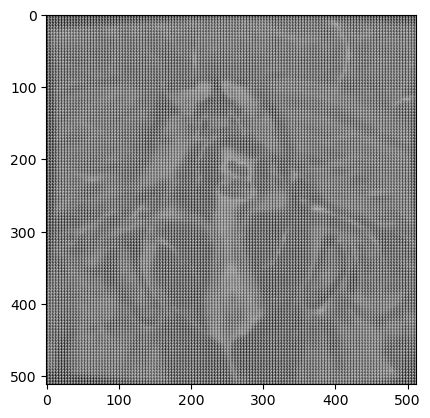

In [15]:
show_output = output.squeeze().detach().cpu().numpy()
plt.imshow(show_output,cmap='gray')

In [16]:
# save model
torch.save(model.state_dict(), 'model.pth')

In [13]:
from google.cloud import storage

def write_read(bucket_name,blob_name=""):
    storage_client = storage.Client()
    
    blobs = storage_client.list_blobs(bucket_name)

    for blob in blobs:
        print(blob.name)

write_read("nanavati_data","nanavati_data/Priyanshi_Nanavati/PA0/ST0")

Anuj_Nanavati/
Anuj_Nanavati/DICOM/PA0/ST0/SE0/IM0
Anuj_Nanavati/DICOM/PA0/ST0/SE0/IM1
Anuj_Nanavati/DICOM/PA0/ST0/SE0/IM10
Anuj_Nanavati/DICOM/PA0/ST0/SE0/IM11
Anuj_Nanavati/DICOM/PA0/ST0/SE0/IM12
Anuj_Nanavati/DICOM/PA0/ST0/SE0/IM13
Anuj_Nanavati/DICOM/PA0/ST0/SE0/IM14
Anuj_Nanavati/DICOM/PA0/ST0/SE0/IM15
Anuj_Nanavati/DICOM/PA0/ST0/SE0/IM16
Anuj_Nanavati/DICOM/PA0/ST0/SE0/IM17
Anuj_Nanavati/DICOM/PA0/ST0/SE0/IM18
Anuj_Nanavati/DICOM/PA0/ST0/SE0/IM19
Anuj_Nanavati/DICOM/PA0/ST0/SE0/IM2
Anuj_Nanavati/DICOM/PA0/ST0/SE0/IM20
Anuj_Nanavati/DICOM/PA0/ST0/SE0/IM3
Anuj_Nanavati/DICOM/PA0/ST0/SE0/IM4
Anuj_Nanavati/DICOM/PA0/ST0/SE0/IM5
Anuj_Nanavati/DICOM/PA0/ST0/SE0/IM6
Anuj_Nanavati/DICOM/PA0/ST0/SE0/IM7
Anuj_Nanavati/DICOM/PA0/ST0/SE0/IM8
Anuj_Nanavati/DICOM/PA0/ST0/SE0/IM9
Anuj_Nanavati/DICOM/PA0/ST0/SE1/IM0
Anuj_Nanavati/DICOM/PA0/ST0/SE1/IM1
Anuj_Nanavati/DICOM/PA0/ST0/SE1/IM10
Anuj_Nanavati/DICOM/PA0/ST0/SE1/IM11
Anuj_Nanavati/DICOM/PA0/ST0/SE1/IM12
Anuj_Nanavati/DICOM/PA0/ST0/SE1/IM1

KeyboardInterrupt: 

In [2]:
import os
for root, folders, files in os.walk("/Users/nilaygaitonde/Documents/Projects/Nanavati/Data/PA0"):
    for file in files:
        print(file)

IM93
IM67
IM115
IM58
IM60
IM94
IM112
IM56
IM69
IM4
IM124
IM51
IM123
IM3
IM177
IM183
IM148
IM184
IM170
IM146
IM34
IM179
IM141
IM33
IM50
IM2
IM122
IM57
IM125
IM68
IM5
IM95
IM61
IM113
IM66
IM92
IM59
IM114
IM140
IM32
IM147
IM178
IM35
IM171
IM185
IM182
IM176
IM149
IM26
IM19
IM154
IM21
IM153
IM17
IM165
IM28
IM191
IM10
IM162
IM136
IM44
IM109
IM131
IM88
IM43
IM107
IM138
IM81
IM75
IM100
IM72
IM86
IM11
IM163
IM16
IM29
IM190
IM164
IM20
IM152
IM27
IM155
IM18
IM101
IM87
IM73
IM106
IM74
IM139
IM80
IM130
IM89
IM42
IM137
IM108
IM45
IM187
IM173
IM174
IM180
IM39
IM142
IM189
IM30
IM145
IM37
IM63
IM97
IM111
IM90
IM129
IM9
IM64
IM116
IM52
IM99
IM120
IM0
IM55
IM118
IM7
IM127
IM144
IM36
IM143
IM188
IM31
IM181
IM38
IM175
IM172
IM186
IM119
IM54
IM126
IM6
IM53
IM1
IM98
IM121
IM8
IM65
IM91
IM128
IM117
IM96
IM62
IM110
IM132
IM40
IM78
IM135
IM47
IM103
IM71
IM85
IM104
IM49
IM82
IM76
IM22
IM150
IM25
IM168
IM157
IM13
IM161
IM159
IM14
IM166
IM48
IM105
IM77
IM83
IM102
IM84
IM70
IM134
IM79
IM46
IM133
IM41
IM15
IM158
IM1

In [24]:
img = dcmread("Data/PA0/ST0/SE2/IM0")
img

Dataset.file_meta -------------------------------
(0002, 0000) File Meta Information Group Length  UL: 194
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: MR Image Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 1.2.840.113619.2.379.176156465384041.25083.1729399784321.52
(0002, 0010) Transfer Syntax UID                 UI: Explicit VR Little Endian
(0002, 0012) Implementation Class UID            UI: 1.2.840.113619.6.379
(0002, 0013) Implementation Version Name         SH: 'aia 6.0 (2.29)'
-------------------------------------------------
(0008, 0000) Group Length                        UL: 912
(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0008) Image Type                          CS: ['ORIGINAL', 'PRIMARY', 'OTHER']
(0008, 0016) SOP Class UID                       UI: MR Image Storage
(0008, 0018) SOP Instance UID                    UI: 1.2.840.113619.2.379.176156465384041.250

In [25]:
import os

for root,folders,files in os.walk("/Users/nilaygaitonde/Documents/Projects/Nanavati/Data/TCGA-D1-A0ZP/06-04-1993-NA-CT ABDOMEN w  PELVIS w-50872/3.000000-Cor AP routine  3.0  B40f-15299"):
    for file in files:
        img = dcmread(os.path.join(root,file))
        print("====\n")
        print(img.PatientName)

====

TCGA-D1-A0ZP
====

TCGA-D1-A0ZP
====

TCGA-D1-A0ZP
====

TCGA-D1-A0ZP
====

TCGA-D1-A0ZP
====

TCGA-D1-A0ZP
====

TCGA-D1-A0ZP
====

TCGA-D1-A0ZP
====

TCGA-D1-A0ZP
====

TCGA-D1-A0ZP
====

TCGA-D1-A0ZP
====

TCGA-D1-A0ZP
====

TCGA-D1-A0ZP
====

TCGA-D1-A0ZP
====

TCGA-D1-A0ZP
====

TCGA-D1-A0ZP
====

TCGA-D1-A0ZP
====

TCGA-D1-A0ZP
====

TCGA-D1-A0ZP
====

TCGA-D1-A0ZP
====

TCGA-D1-A0ZP
====

TCGA-D1-A0ZP
====

TCGA-D1-A0ZP
====

TCGA-D1-A0ZP
====

TCGA-D1-A0ZP
====

TCGA-D1-A0ZP
====

TCGA-D1-A0ZP
====

TCGA-D1-A0ZP
====

TCGA-D1-A0ZP
====

TCGA-D1-A0ZP
====

TCGA-D1-A0ZP
====

TCGA-D1-A0ZP
====

TCGA-D1-A0ZP
====

TCGA-D1-A0ZP
====

TCGA-D1-A0ZP
====

TCGA-D1-A0ZP
====

TCGA-D1-A0ZP
====

TCGA-D1-A0ZP
====

TCGA-D1-A0ZP
====

TCGA-D1-A0ZP
====

TCGA-D1-A0ZP
====

TCGA-D1-A0ZP
====

TCGA-D1-A0ZP
====

TCGA-D1-A0ZP
====

TCGA-D1-A0ZP
====

TCGA-D1-A0ZP
====

TCGA-D1-A0ZP
====

TCGA-D1-A0ZP
====

TCGA-D1-A0ZP
====

TCGA-D1-A0ZP
====

TCGA-D1-A0ZP
====

TCGA-D1-A0ZP
====

TCGA-D

In [95]:
from google.cloud import storage

def list_folders(bucket_name, prefix=""):
    """Lists folders (prefixes) in a GCS bucket.

    Args:
    bucket_name: The name of the bucket.
    prefix: The prefix to filter the results.

    Returns:
    A list of folder names.
    """

    storage_client = storage.Client()
    bucket = storage_client.bucket(bucket_name)

    # blobs = bucket.list_blobs(prefix=prefix, delimiter="/")
    blobs = bucket.list_blobs(prefix=prefix)

    folders = [blob.name for blob in blobs]
    print(folders)

    blobs = bucket.list_blobs(prefix=prefix,delimiter="/")

    folders = [blob.name for blob in blobs]
    return folders

# Example usage:
bucket_name = "nanavati_data"
prefix = "Anuj_Nanavati/DICOM/PA0/ST0/SE0"  # Optional: to list folders within a specific prefix

folder_names = list_folders(bucket_name,prefix)
print(folder_names)

['Anuj_Nanavati/DICOM/PA0/ST0/SE0/IM0', 'Anuj_Nanavati/DICOM/PA0/ST0/SE0/IM1', 'Anuj_Nanavati/DICOM/PA0/ST0/SE0/IM10', 'Anuj_Nanavati/DICOM/PA0/ST0/SE0/IM11', 'Anuj_Nanavati/DICOM/PA0/ST0/SE0/IM12', 'Anuj_Nanavati/DICOM/PA0/ST0/SE0/IM13', 'Anuj_Nanavati/DICOM/PA0/ST0/SE0/IM14', 'Anuj_Nanavati/DICOM/PA0/ST0/SE0/IM15', 'Anuj_Nanavati/DICOM/PA0/ST0/SE0/IM16', 'Anuj_Nanavati/DICOM/PA0/ST0/SE0/IM17', 'Anuj_Nanavati/DICOM/PA0/ST0/SE0/IM18', 'Anuj_Nanavati/DICOM/PA0/ST0/SE0/IM19', 'Anuj_Nanavati/DICOM/PA0/ST0/SE0/IM2', 'Anuj_Nanavati/DICOM/PA0/ST0/SE0/IM20', 'Anuj_Nanavati/DICOM/PA0/ST0/SE0/IM3', 'Anuj_Nanavati/DICOM/PA0/ST0/SE0/IM4', 'Anuj_Nanavati/DICOM/PA0/ST0/SE0/IM5', 'Anuj_Nanavati/DICOM/PA0/ST0/SE0/IM6', 'Anuj_Nanavati/DICOM/PA0/ST0/SE0/IM7', 'Anuj_Nanavati/DICOM/PA0/ST0/SE0/IM8', 'Anuj_Nanavati/DICOM/PA0/ST0/SE0/IM9']
[]


In [ ]:
"""
1. Read all the patients from the bucket
2. For each patient figure out the Axial scans
3. Once we've figured out the Axial scans, we can start working on the pre-processing
4. Once we've done the pre-processing we can start working on the model
"""

In [92]:
'Anuj_Nanavati/DICOM/PA0/ST0/SE0/IM0'.split("/")[-2]

'SE0'

In [ ]:
class Patient(Dataset):
    def __init__(self,patient_name,patient_age,location,img_array):
        super().__init__()
        self.patient_name = patient_name
        self.patient_age = patient_age
        self.location = location
        self.img_array = img_array
    
    def __len__(self):
        

In [131]:
from google.cloud import storage
from pydicom import dcmread
import pandas as pd
import tempfile

def get_views(bucket_name:str,prefix:str)->list:

    """
        Return a list of all the views for a patient
    """

    storage_client = storage.Client()
    bucket = storage_client.bucket(bucket_name)
    blobs = bucket.list_blobs(prefix=prefix)
    views = []
    for blob in blobs:
        views.append(blob.name.split("/")[-2])
    return list(set(views))

def get_axial_view(bucket_name:str,prefix:str) -> pd.DataFrame:
    storage_client = storage.Client()
    bucket = storage_client.bucket(bucket_name)
    blobs = bucket.list_blobs(prefix=prefix)
    axialT2 = pd.DataFrame()
    
    for blob in blobs:
        file_name = blob.download_as_bytes()
        with tempfile.NamedTemporaryFile(delete=False) as temp_file:
            temp_file.write(file_name)
            temp_file_path = temp_file.name
        img = dcmread(f"{temp_file_path}")
        if img.SeriesDescription in ["Ax T2","Axial T2"]:
            # add to patient dataset
            temp = pd.DataFrame({"PatientName":str(img.PatientName.family_comma_given()),"PatientAge":img.PatientAge,"Location":blob.name},index=[0])
            axialT2 = pd.concat([axialT2,temp],ignore_index=True,axis=0)
        else:
            print("Not Axial T2 view",prefix)
            return None
    print("Axial View",prefix)
    return axialT2.reset_index(drop=True)

all_axialT2 = pd.DataFrame()
for patient in range(1,11):
    views = get_views("nanavati_data",f"Priyanshi_Nanavati/PA{patient}/ST0")
    if len(views) > 0:
        for view in views:
            axialT2 = get_axial_view("nanavati_data",f"Priyanshi_Nanavati/PA{patient}/ST0/{view}")
            if axialT2 is not None:
                all_axialT2 = pd.concat([all_axialT2,axialT2],ignore_index=True,axis=0)
                break
    else:
        print("No views found for patient",patient)
        break

Axial View Priyanshi_Nanavati/PA1/ST0/SE3


,PatientName,PatientAge,Location
0,"Priyanshi, Fib3",036Y,Priyanshi_Nanavati/PA1/ST0/SE3/IM0
1,"Priyanshi, Fib3",036Y,Priyanshi_Nanavati/PA1/ST0/SE3/IM1
2,"Priyanshi, Fib3",036Y,Priyanshi_Nanavati/PA1/ST0/SE3/IM10
3,"Priyanshi, Fib3",036Y,Priyanshi_Nanavati/PA1/ST0/SE3/IM11
4,"Priyanshi, Fib3",036Y,Priyanshi_Nanavati/PA1/ST0/SE3/IM12
5,"Priyanshi, Fib3",036Y,Priyanshi_Nanavati/PA1/ST0/SE3/IM13
6,"Priyanshi, Fib3",036Y,Priyanshi_Nanavati/PA1/ST0/SE3/IM14
7,"Priyanshi, Fib3",036Y,Priyanshi_Nanavati/PA1/ST0/SE3/IM15
8,"Priyanshi, Fib3",036Y,Priyanshi_Nanavati/PA1/ST0/SE3/IM16
9,"Priyanshi, Fib3",036Y,Priyanshi_Nanavati/PA1/ST0/SE3/IM17


In [66]:
from google.cloud import storage
from pydicom import dcmread
import pandas as pd
import tempfile


axialT2 = pd.DataFrame()
root_folders = ["Anuj_Nanavati","Priyanshi_Nanavati"]

def write_read(bucket_name):
    storage_client = storage.Client()
    bucket = storage_client.bucket(bucket_name)
    
    blobs = bucket.list_blobs(prefix="Anuj_Nanavati/DICOM/PA0/ST0")

    for blob in blobs:
        print("===\n")
        name = blob.name
        if name.endswith("/"):
            print(f"Folder:{name}")
        else:
            file_name = blob.download_as_bytes()
            with tempfile.NamedTemporaryFile(delete=False) as temp_file:
                temp_file.write(file_name)
                temp_file_path = temp_file.name
            img = dcmread(f"{temp_file_path}")
            print(img.SeriesDescription)
            if img.SeriesDescription in ["Ax T2","Axial T2"]:
                print(f"Axial T2:{name}")
                new_row = {"PatientName":img.PatientName,"PatientAge":img.PatientAge,"PatientSex":img.PatientSex,"File Location":name}
                axialT2 = pd.concat([axialT2,pd.DataFrame(new_row,index=[0])],axis=0)
                print(axialT2.shape)
            # print(f"File:{name}")

            

write_read("nanavati_data")

===

Folder:Anuj_Nanavati/
===

3-Plane Loc
===

3-Plane Loc
===

3-Plane Loc
===

3-Plane Loc
===

3-Plane Loc
===

3-Plane Loc
===

3-Plane Loc
===

3-Plane Loc
===

3-Plane Loc
===

3-Plane Loc
===

3-Plane Loc
===

3-Plane Loc
===

3-Plane Loc
===

3-Plane Loc
===

3-Plane Loc
===

3-Plane Loc
===

3-Plane Loc
===

3-Plane Loc
===

3-Plane Loc
===

3-Plane Loc
===

3-Plane Loc
===

3-Plane Loc
===

3-Plane Loc
===

3-Plane Loc
===

3-Plane Loc
===

3-Plane Loc
===

3-Plane Loc
===

3-Plane Loc
===

3-Plane Loc
===

3-Plane Loc
===

3-Plane Loc
===

3-Plane Loc
===

3-Plane Loc
===

3-Plane Loc
===

3-Plane Loc
===

3-Plane Loc
===

3-Plane Loc
===

3-Plane Loc
===

3-Plane Loc
===

3-Plane Loc
===

3-Plane Loc
===

3-Plane Loc
===

3-Plane Loc
===

3-Plane Loc
===

3-Plane Loc
===

3-Plane Loc
===

3-Plane Loc
===

3-Plane Loc
===

3-Plane Loc
===

3-Plane Loc
===

3-Plane Loc
===

3-Plane Loc
===

3-Plane Loc
===

3-Plane Loc
===

3-Plane Loc
===

3-Plane Loc
===

3-Plane Loc
===


KeyboardInterrupt: 

In [2]:
"""
1. Read all the patients from the bucket
2. For each patient figure out the Axial scans
3. Once we've figured out the Axial scans, we can start working on the pre-processing
4. Once we've done the pre-processing we can start working on the model
"""

from google.cloud import storage
from pydicom import dcmread
import pandas as pd
import tempfile
from PatientClass import MRUterusDataset


def get_views(bucket_name:str,prefix:str)->list:

    """
        Return a list of all the views for a patient
    """
    storage_client = storage.Client()
    bucket = storage_client.bucket(bucket_name)
    blobs = bucket.list_blobs(prefix=prefix)
    views = []
    for blob in blobs:
        views.append(blob.name.split("/")[-2])
    return list(set(views))

def get_axial_view(bucket_name:str,prefix:str,dataset:MRUterusDataset) -> pd.DataFrame:
    storage_client = storage.Client()
    bucket = storage_client.bucket(bucket_name)
    blobs = bucket.list_blobs(prefix=prefix)
    axialT2 = pd.DataFrame()
    
    for blob in blobs:
        file_name = blob.download_as_bytes()
        with tempfile.NamedTemporaryFile(delete=False) as temp_file:
            temp_file.write(file_name)
            temp_file_path = temp_file.name
        img = dcmread(f"{temp_file_path}")
        if img.SeriesDescription in ["Ax T2","Axial T2"]:
            # add to patient dataset
            dataset.add_dicom_file(img,has_fibroid=None)
        else:
            print("Not Axial T2 view",prefix)
            return False
    print("Axial View",prefix)
    return True

def get_data(bucket_name:str,prefix:str):
    dataset = MRUterusDataset(data_dir = "imgs/")
    for patient in range(1,2):
        views = get_views(bucket_name,f"{prefix}/PA{patient}/ST0")
        if len(views) > 0:
            for view in views:
                axialT2 = get_axial_view(bucket_name,f"{prefix}/PA{patient}/ST0/{view}",dataset)
                if not axialT2:
                    continue  
        else:
            print("No views found for patient",patient)
            break
        break
    return dataset
    


dataset = get_data("nanavati_data","Priyanshi_Nanavati")

Not Axial T2 view Priyanshi_Nanavati/PA1/ST0/SE12
Not Axial T2 view Priyanshi_Nanavati/PA1/ST0/SE21
Not Axial T2 view Priyanshi_Nanavati/PA1/ST0/SE0
Not Axial T2 view Priyanshi_Nanavati/PA1/ST0/SE9
Not Axial T2 view Priyanshi_Nanavati/PA1/ST0/SE17
Not Axial T2 view Priyanshi_Nanavati/PA1/ST0/SE1
Not Axial T2 view Priyanshi_Nanavati/PA1/ST0/SE5
Not Axial T2 view Priyanshi_Nanavati/PA1/ST0/SE8
Not Axial T2 view Priyanshi_Nanavati/PA1/ST0/SE10
Not Axial T2 view Priyanshi_Nanavati/PA1/ST0/SE7
Not Axial T2 view Priyanshi_Nanavati/PA1/ST0/SE11
Not Axial T2 view Priyanshi_Nanavati/PA1/ST0/SE14
Not Axial T2 view Priyanshi_Nanavati/PA1/ST0/SE15
Not Axial T2 view Priyanshi_Nanavati/PA1/ST0/SE19


/Users/nilaygaitonde/Documents/Projects/Nanavati/PatientClass.py:106: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self.series_df = pd.concat([self.series_df, new_series], ignore_index=True)
/Users/nilaygaitonde/Documents/Projects/Nanavati/PatientClass.py:122: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self.slice_df = pd.concat([self.slice_df, new_slice], ignore_index=True)


Axial View Priyanshi_Nanavati/PA1/ST0/SE3
Not Axial T2 view Priyanshi_Nanavati/PA1/ST0/SE16
Not Axial T2 view Priyanshi_Nanavati/PA1/ST0/SE18
Not Axial T2 view Priyanshi_Nanavati/PA1/ST0/SE4
Not Axial T2 view Priyanshi_Nanavati/PA1/ST0/SE20
Not Axial T2 view Priyanshi_Nanavati/PA1/ST0/SE2
Not Axial T2 view Priyanshi_Nanavati/PA1/ST0/SE6
Not Axial T2 view Priyanshi_Nanavati/PA1/ST0/SE13


In [12]:
import matplotlib.pyplot as plt

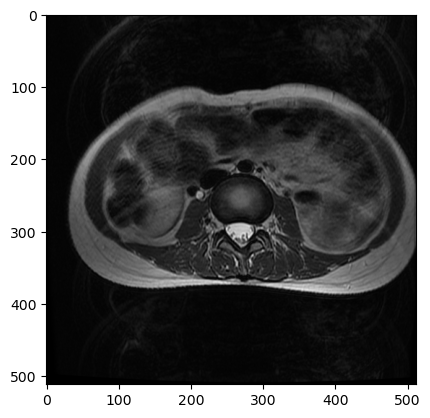

In [14]:
plt.imshow(dataset[0]['image'].numpy(),cmap="gray")

In [17]:
dataset[0].keys()

dict_keys(['image', 'slice_metadata', 'series_metadata', 'study_metadata', 'patient_metadata', 'has_fibroid'])